<a href="https://colab.research.google.com/github/gaboojie/project_voting/blob/main/%5Bignore%5D%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plan:
1. Load CSV va_voting data - Gabe
2. Clean data into proper format for ML model - Gabe
3. Create correct linear regression model - Ben
4. Calculate metrics to assess the linear regression model - Ben
5. Use model to predict 2024 votes - Ben
6. Calculate net votes for each county using predicted values - Ben
7. Create a state map based on 2024 inputs to the model - Naad

In [1]:
# 1. Load CSV va_voting data

import pandas as pd
import numpy as np

csv_df = pd.read_csv("https://raw.githubusercontent.com/gaboojie/project_voting/main/data/voting_VA.csv")

In [22]:
# 2. Clean data into proper format for ML model

# Independent variables to use:
# - Year
# - County Name
# - Total votes
# - Party (Republican or Democrat)

# Dependent variables to use:
# - Candidate votes

# Rename columns
df = csv_df.rename(columns={'year': 'Year', 'county_name': 'County Name', 'party': 'Party', 'totalvotes': 'Total Votes', 'candidatevotes': 'Candidate Votes', 'candidate': 'Candidate'})

# Clean Party: only include Republican and Democrat parties, drop any other party rows
df_index = df[ (df['Party'] != 'REPUBLICAN') & (df['Party'] != 'DEMOCRAT') ].index
df = df.drop(df_index)
print("Unique parties:", df['Party'].unique())

# Clean Year: Already looks good
print("Unique years:", df['Year'].unique())

# Clean County name: Already looks good
#print("Unique counties:", df['County Name'].unique())
print('Number of NAs in counties:', df['County Name'].isna().sum())

# Clean total votes: Drop any total where votes are less than 1 (there were two outliers for 2016 in Bedford with a vote count of 0)
df_index = df[df['Total Votes'] <= 0].index
df = df.drop(df_index)
print("Number of NAs in Total Votes:", df['Total Votes'].isna().sum())
#print(df['Total Votes'].unique())

# Merge 2020 absentee, election day, and provisional votes to one candidate vote
county_total_votes = df[['County Name', 'Candidate', 'Year', 'Total Votes']].drop_duplicates()

biden_entries = df[(df['Candidate'] == 'JOSEPH R BIDEN JR') & (df['Year'] == 2020)].groupby(['County Name', 'state', 'state_po', 'office', 'Candidate', 'Year', 'Party', 'county_fips']).agg({'Candidate Votes': 'sum'}).reset_index()
biden_entries = pd.merge(biden_entries, county_total_votes, on=['County Name', 'Candidate', 'Year'], how='left')
df = df[df['Candidate'] != 'JOSEPH R BIDEN JR']
df = pd.concat([df, biden_entries], ignore_index=True)
print(biden_entries)

trump_entries = df[(df['Candidate'] == 'DONALD J TRUMP') & (df['Year'] == 2020)].groupby(['County Name', 'state', 'state_po', 'office', 'Candidate', 'Year', 'Party', 'county_fips']).agg({'Candidate Votes': 'sum'}).reset_index()
trump_entries = pd.merge(trump_entries, county_total_votes, on=['County Name', 'Candidate', 'Year'], how='left')
df = df[df['Candidate'] != 'DONALD J TRUMP']
df = pd.concat([df, trump_entries], ignore_index=True)
print(trump_entries)

# Clean candidate votes: Drop any total where votes are less than 1 (there were two outliers for 2016 in Bedford with a vote count of 0)
df_index = df[df['Candidate Votes'] <= 0].index
df = df.drop(df_index)
print("Number of NAs in Candidate Votes:", df['Total Votes'].isna().sum())
#print(df['Candidate Votes'].unique())

display(df)

Unique parties: ['DEMOCRAT' 'REPUBLICAN']
Unique years: [2000 2004 2008 2012 2016 2020]
Number of NAs in counties: 0
Number of NAs in Total Votes: 0
           County Name     state state_po        office          Candidate  \
0             ACCOMACK  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN JR   
1            ALBEMARLE  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN JR   
2      ALEXANDRIA CITY  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN JR   
3            ALLEGHANY  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN JR   
4               AMELIA  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN JR   
..                 ...       ...      ...           ...                ...   
128  WILLIAMSBURG CITY  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN JR   
129    WINCHESTER CITY  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN JR   
130               WISE  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN JR   
131              WYTHE  VIRGINIA       VA  US PRESIDENT  JOSEPH R BIDEN

,Unnamed: 0,Year,state,state_po,County Name,county_fips,office,Candidate,Party,Candidate Votes,Total Votes,version,mode
0,11161.0,2000,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,AL GORE,DEMOCRAT,5092,11925,20220315.0,TOTAL
1,11162.0,2000,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,6352,11925,20220315.0,TOTAL
2,11165.0,2000,VIRGINIA,VA,ALBEMARLE,51003,US PRESIDENT,AL GORE,DEMOCRAT,16255,36846,20220315.0,TOTAL
3,11166.0,2000,VIRGINIA,VA,ALBEMARLE,51003,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,18291,36846,20220315.0,TOTAL
4,11169.0,2000,VIRGINIA,VA,ALLEGHANY,51005,US PRESIDENT,AL GORE,DEMOCRAT,2214,5123,20220315.0,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,NaN,2020,VIRGINIA,VA,WILLIAMSBURG CITY,51830,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,1963,6890,NaN,NaN
1600,NaN,2020,VIRGINIA,VA,WINCHESTER CITY,51840,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,5221,12113,NaN,NaN
1601,NaN,2020,VIRGINIA,VA,WISE,51195,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,13366,16615,NaN,NaN
1602,NaN,2020,VIRGINIA,VA,WYTHE,51197,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,11733,15073,NaN,NaN


In [27]:
df['County Name'].unique()

array(['ACCOMACK', 'ALBEMARLE', 'ALLEGHANY', 'AMELIA', 'AMHERST',
       'APPOMATTOX', 'ARLINGTON', 'AUGUSTA', 'BATH', 'BEDFORD', 'BLAND',
       'BOTETOURT', 'BRUNSWICK', 'BUCHANAN', 'BUCKINGHAM', 'CAMPBELL',
       'CAROLINE', 'CARROLL', 'CHARLES CITY', 'CHARLOTTE', 'CHESTERFIELD',
       'CLARKE', 'CRAIG', 'CULPEPER', 'CUMBERLAND', 'DICKENSON',
       'DINWIDDIE', 'ESSEX', 'FAIRFAX', 'FAUQUIER', 'FLOYD', 'FLUVANNA',
       'FRANKLIN', 'FREDERICK', 'GILES', 'GLOUCESTER', 'GOOCHLAND',
       'GRAYSON', 'GREENE', 'GREENSVILLE', 'HALIFAX', 'HANOVER',
       'HENRICO', 'HENRY', 'HIGHLAND', 'ISLE OF WIGHT', 'JAMES CITY',
       'KING AND QUEEN', 'KING GEORGE', 'KING WILLIAM', 'LANCASTER',
       'LEE', 'LOUDOUN', 'LOUISA', 'LUNENBURG', 'MADISON', 'MATHEWS',
       'MECKLENBURG', 'MIDDLESEX', 'MONTGOMERY', 'NELSON', 'NEW KENT',
       'NORTHAMPTON', 'NORTHUMBERLAND', 'NOTTOWAY', 'ORANGE', 'PAGE',
       'PATRICK', 'PITTSYLVANIA', 'POWHATAN', 'PRINCE EDWARD',
       'PRINCE GEORGE', 'PRINCE

In [34]:
df['Candidate'].unique()

array(['AL GORE', 'GEORGE W. BUSH', 'JOHN KERRY', 'BARACK OBAMA',
       'JOHN MCCAIN', 'MITT ROMNEY', 'HILLARY CLINTON', 'DONALD TRUMP',
       'JOSEPH R BIDEN JR', 'DONALD J TRUMP'], dtype=object)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# 3. Create a linear regression model using the data
X = pd.get_dummies(df['Candidate'], dtype='int')  # One-hot encode the 'Candidate' column
X_party = pd.get_dummies(df['Party'], dtype='int')  # One-hot encode the 'Party' column
X_county = pd.get_dummies(df['County Name'], dtype='int') # One-hot encode the 'County Name' column
y = df['Candidate Votes']  # Assuming 'Candidate Votes' is your target variable

# Add the 'Total Votes' column as an additional feature
X['Total Votes'] = df['Total Votes']

# Use PolynomialFeatures to generate interaction terms up to degree 2
expander = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = expander.fit_transform(X)

# Convert X_interactions to a DataFrame
X_interactions_df = pd.DataFrame(X_interactions, columns=expander.get_feature_names_out(X.columns))

# Concatenate X_interactions_df with the other dummy variables
X_final = pd.concat([X_interactions_df, X_party, X_county], axis=1)

# Fit a linear regression model
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=False).fit(X_final, y)

results = pd.DataFrame({'Variables':reg.feature_names_in_, 'Coefficient':reg.coef_})
results





,Variables,Coefficient
0,AL GORE,-4.819594e+07
1,BARACK OBAMA,-4.819724e+07
2,DONALD J TRUMP,7.664185e+10
3,DONALD TRUMP,7.664185e+10
4,GEORGE W. BUSH,7.664184e+10
...,...,...
230,WINCHESTER,-4.000231e+08
231,WINCHESTER CITY,-4.000231e+08
232,WISE,-4.000230e+08
233,WYTHE,-4.000230e+08


In [21]:
sorted_df = results.sort_values(by='Coefficient', ascending=True)
sorted_df

,Variables,Coefficient
12,AL GORE DONALD J TRUMP,-3.572592e+11
18,AL GORE JOSEPH R BIDEN JR,-2.749271e+11
16,AL GORE JOHN KERRY,-8.774195e+10
21,BARACK OBAMA DONALD J TRUMP,-8.075135e+10
14,AL GORE GEORGE W. BUSH,-7.757942e+10
...,...,...
2,DONALD J TRUMP,7.664185e+10
15,AL GORE HILLARY CLINTON,1.681504e+11
22,BARACK OBAMA DONALD TRUMP,2.003519e+11
17,AL GORE JOHN MCCAIN,2.059024e+11


In [4]:
# 4. Calculate metrics to asses the model
# Calculate R^2
r2 = reg.score(X_final, y)
print('R_squared: ', r2)

R_squared:  0.9661787960748086


In [5]:
# 5. Use model to predict 2024 votes - Ben
# Calculate total votes growth rates
total_votes = df.groupby(['County Name', 'Year'])['Total Votes'].sum().reset_index()

# Merge DataFrame with itself, shifted by one term, to align total votes for consecutive
total_votes_shifted = total_votes.copy()
total_votes_shifted['Year'] = total_votes_shifted['Year'] + 4
total_votes_merged = pd.merge(total_votes, total_votes_shifted, on=['County Name', 'Year'], suffixes=('', '_prev'), how='left')

# Calculate growth rate as the percentage change between total votes in current term and previous term
total_votes_merged['Growth Rate'] = ((total_votes_merged['Total Votes'] - total_votes_merged['Total Votes_prev']) / total_votes_merged['Total Votes_prev']) * 100
print(total_votes_merged)

average_growth_rate = total_votes_merged.groupby('County Name')['Growth Rate'].mean().reset_index()

# Display the average growth rate per county
print(average_growth_rate)
average_growth_rate.head()

    County Name  Year  Total Votes  Total Votes_prev  Growth Rate
0      ACCOMACK  2000        23850               NaN          NaN
1      ACCOMACK  2004        26712           23850.0    12.000000
2      ACCOMACK  2008        31246           26712.0    16.973645
3      ACCOMACK  2012        32102           31246.0     2.739551
4      ACCOMACK  2016        31636           32102.0    -1.451623
..          ...   ...          ...               ...          ...
773        YORK  2004        59760           49166.0    21.547411
774        YORK  2008        67794           59760.0    13.443775
775        YORK  2012        67906           67794.0     0.165206
776        YORK  2016        68236           67906.0     0.485966
777        YORK  2020        77582           68236.0    13.696582

[778 rows x 5 columns]
         County Name  Growth Rate
0           ACCOMACK     7.498768
1          ALBEMARLE    12.042985
2         ALEXANDRIA     8.342775
3    ALEXANDRIA CITY          NaN
4          ALL

,County Name,Growth Rate
0,ACCOMACK,7.498768
1,ALBEMARLE,12.042985
2,ALEXANDRIA,8.342775
3,ALEXANDRIA CITY,NaN
4,ALLEGHANY,10.861802


In [19]:
sorted_df = average_growth_rate.sort_values(by='Growth Rate', ascending=False)
sorted_df.head()

,County Name,Growth Rate
86,LOUDOUN,24.795890
160,WILLIAMSBURG,21.416115
80,KING GEORGE,20.034121
94,MANASSAS PARK,19.557972
103,NEW KENT,19.061035


In [6]:
# Use growth rates and 2020 total votes to derive 2024 total votes
estimated_votes_2024 = total_votes_merged[['County Name', 'Year', 'Total Votes']]
df_index = estimated_votes_2024[estimated_votes_2024['Year'] != 2020].index
estimated_votes_2024 = estimated_votes_2024.drop(df_index)
estimated_votes_2024 = pd.merge(estimated_votes_2024, average_growth_rate, on=['County Name'], how='left')
estimated_votes_2024['Estimated Total Votes 2024'] = estimated_votes_2024['Total Votes'] * (1 + average_growth_rate['Growth Rate'] / 100)
print(estimated_votes_2024)

           County Name  Year  Total Votes  Growth Rate  \
0             ACCOMACK  2020        33924     7.498768   
1            ALBEMARLE  2020       129314    12.042985   
2      ALEXANDRIA CITY  2020       165042          NaN   
3            ALLEGHANY  2020        16406    10.861802   
4               AMELIA  2020        15788    10.708869   
..                 ...   ...          ...          ...   
128  WILLIAMSBURG CITY  2020        13780          NaN   
129    WINCHESTER CITY  2020        24226          NaN   
130               WISE  2020        33230     4.615644   
131              WYTHE  2020        30146     8.195736   
132               YORK  2020        77582     9.867788   

     Estimated Total Votes 2024  
0                  36467.882026  
1                 144887.264999  
2                 178811.082656  
3                           NaN  
4                  17502.861378  
..                          ...  
128                14921.414350  
129                         NaN

In [30]:
# Use linear regression model to predict democrat and republican votes
dem_df = pd.merge(df, estimated_votes_2024[['County Name', 'Estimated Total Votes 2024']], on='County Name', how='left')
dem_df = dem_df.drop(['Total Votes'], axis=1)
dem_df = dem_df.rename(columns={'Estimated Votes 2024': 'Total Votes'})

X = pd.get_dummies(df['Candidate'], dtype='int')  # One-hot encode the 'Candidate' column
X_party = pd.get_dummies(df['Party'], dtype='int')  # One-hot encode the 'Party' column
X_county = pd.get_dummies(df['County Name'], dtype='int') # One-hot encode the 'County Name' column
# Add the 'Total Votes' column as an additional feature
X['Total Votes'] = df['Total Votes']

# Use PolynomialFeatures to generate interaction terms up to degree 2
expander = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = expander.fit_transform(X)

# Convert X_interactions to a DataFrame
X_interactions_df = pd.DataFrame(X_interactions, columns=expander.get_feature_names_out(X.columns))

# Concatenate X_interactions_df with the party dummy variables
X_final = pd.concat([X_interactions_df, X_party, X_county], axis=1)

df_index = X_final[X_final['JOSEPH R BIDEN JR'] != 1].index
reg_dem_df = X_final.drop(df_index)
df_index = dem_df[dem_df['Candidate'] != 'JOSEPH R BIDEN JR'].index
dem_df = dem_df.drop(df_index)

dem_df['Candidate Votes'] = reg.predict(reg_dem_df)
# print(dem_df)
dem_df.head()

rep_df = pd.merge(df, estimated_votes_2024[['County Name', 'Estimated Total Votes 2024']], on='County Name', how='left')
rep_df = rep_df.drop(['Total Votes'], axis=1)
rep_df = rep_df.rename(columns={'Estimated Votes 2024': 'Total Votes'})
# Add the 'Total Votes' column as an additional feature
X = pd.get_dummies(df['Candidate'], dtype='int')  # One-hot encode the 'Candidate' column
X_party = pd.get_dummies(df['Party'], dtype='int')  # One-hot encode the 'Party' column
X_county = pd.get_dummies(df['County Name'], dtype='int') # One-hot encode the 'County Name' column
X['Total Votes'] = df['Total Votes']

# Use PolynomialFeatures to generate interaction terms up to degree 2
expander = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = expander.fit_transform(X)

# Convert X_interactions to a DataFrame
X_interactions_df = pd.DataFrame(X_interactions, columns=expander.get_feature_names_out(X.columns))

# Concatenate X_interactions_df with the party dummy variables
X_final = pd.concat([X_interactions_df, X_party, X_county], axis=1)

df_index = X_final[X_final['DONALD J TRUMP'] != 1].index
reg_rep_df = X_final.drop(df_index)
df_index = rep_df[rep_df['Candidate'] != 'DONALD J TRUMP'].index
rep_df = rep_df.drop(df_index)

rep_df['Candidate Votes'] = reg.predict(reg_rep_df) * -1
# rep_df


In [31]:
# 6. Calculate net votes for each county using predicted values
df_2024 = pd.concat([dem_df, rep_df], ignore_index=True)

df_2024 = df_2024.groupby(['County Name', 'county_fips'])['Candidate Votes'].sum().reset_index()

df_2024

,County Name,county_fips,Candidate Votes
0,ACCOMACK,51001,-2408.759674
1,ALBEMARLE,51003,14250.927826
2,ALEXANDRIA CITY,51510,20490.802826
3,ALLEGHANY,51005,-5468.275299
4,AMELIA,51007,-5576.212799
...,...,...,...
128,WILLIAMSBURG CITY,51830,-5926.900299
129,WINCHESTER CITY,51840,-4102.478424
130,WISE,51195,-2529.947174
131,WYTHE,51197,-3068.554134


In [32]:
df_2024['Candidate Votes'].sum()

450409.6355781555

In [9]:
!pip install mapclassify

In [14]:
# 7. Create a state map based on 2024 inputs to the model
import geopandas as gpd
import mapclassify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load data
gdf = gpd.read_file('/content/VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
cdf = pd.read_csv('https://raw.githubusercontent.com/gaboojie/project_voting/main/data/county_adjacencies.csv') # Load county adjacency data and population data

# Merge shapefile data and county adjacency data:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')  # merge county population and adjacency data into df
del gdf, cdf

ERROR:fiona._env:Unable to open /content/VirginiaCounty_ClippedToShoreline.shp or /content/VirginiaCounty_ClippedToShoreline.SHP.


DriverError: Unable to open /content/VirginiaCounty_ClippedToShoreline.shp or /content/VirginiaCounty_ClippedToShoreline.SHP.

AttributeError: Line2D.set() got an unexpected keyword argument 'cax'

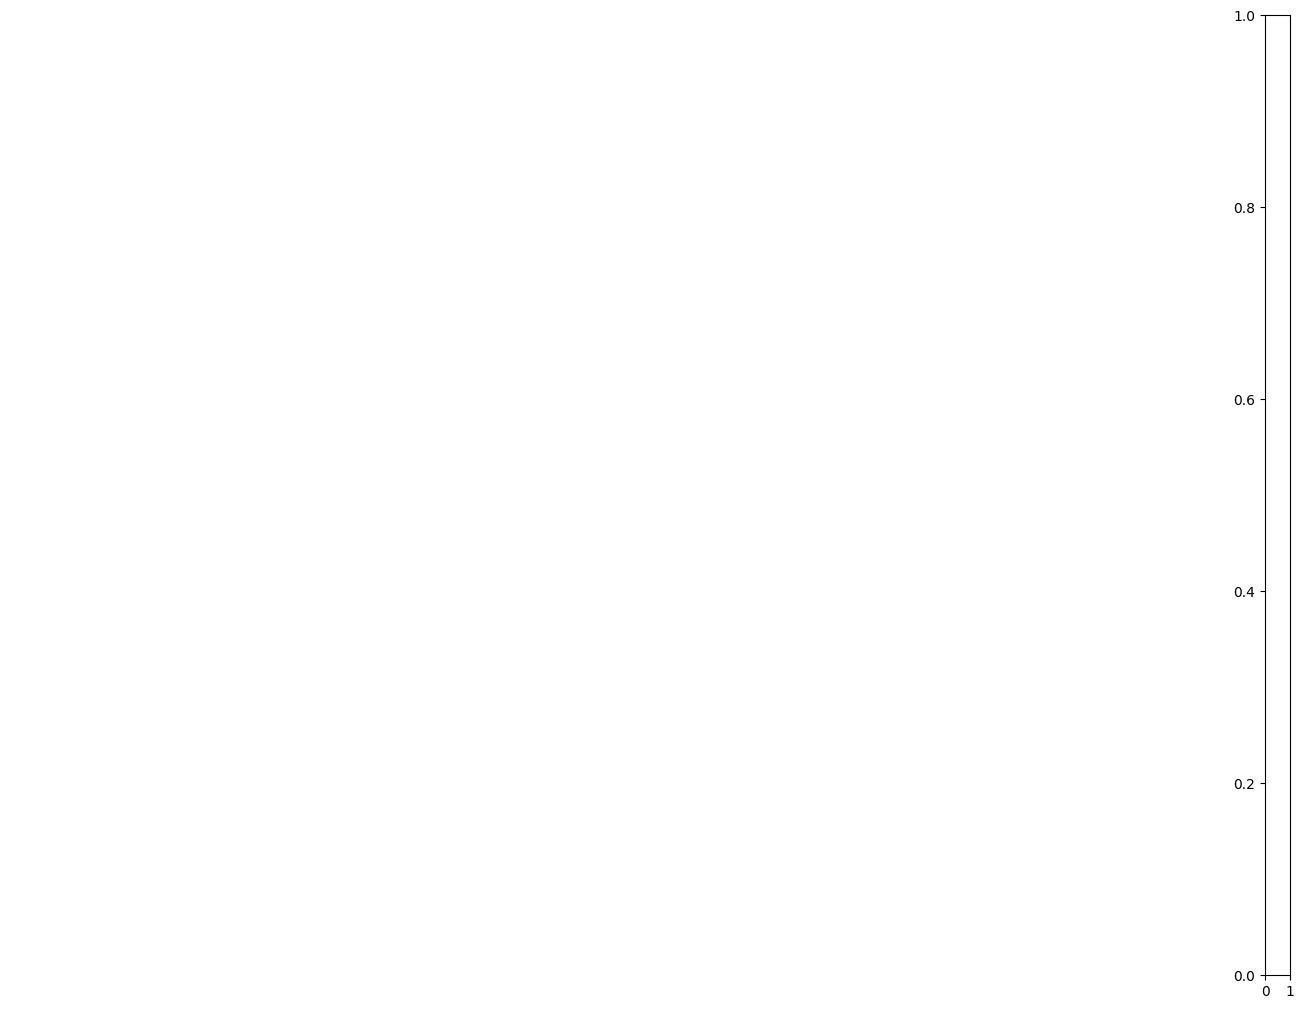

In [15]:
df['vote_diff_ihs'] = np.arcsinh(df_2024['Candidate Votes'])

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax, column='vote_diff_ihs', legend=True, cax=cax, cmap='bwr_r', edgecolor='k')


The map of Virginia displays the transformed net votes for the 2024 predictions, highlighting regional voting trends with a blue to red gradient where blue indicates a preference for one candidate and red for another. Northern Virginia shows a competitive mix of colors, reflecting its diverse political landscape, while southern regions are predominantly red, indicating a stronger preference for the opposing candidate. This geographic visualization helps in identifying key battleground areas and understanding demographic influences on voting behaviors, which could be pivotal for future political strategies and campaigns.
